In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

The data can be imported directly from Kaggle.

In [2]:
# # Use ! to execute a shell command from the notebook
!ls /kaggle/input/umr-ml-2025-hackathon-1/

data_test.csv  data_train.csv  test_submission.csv


Let's load the dataset into a Pandas DataFrame.

In [3]:
df_train = pd.read_csv("/kaggle/input/umr-ml-2025-hackathon-1/data_train.csv")

In [4]:
# Show the first five rows. .tail() for the last five
df_train.head()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday_indicator,public_holiday_indicator,is_workday
0,2012-04-25,4593.0,12.038889,65.611111,3.033333,183.333333,53611.111111,0.0,294,12.0,0.0,0.0,0,0,1
1,2012-04-26,5849.0,14.194444,66.111111,2.844444,249.444444,52555.555556,0.0,176,10.0,0.0,0.0,0,0,1
2,2012-04-27,5846.0,15.233333,68.666667,1.505556,235.000000,45055.555556,0.1,373,5.0,0.0,0.0,0,0,1
3,2012-04-28,4261.0,22.200000,53.444444,2.700000,153.888889,41500.000000,0.0,678,8.0,0.0,0.0,0,0,0
4,2012-04-29,1901.0,17.994444,62.222222,3.950000,214.444444,52777.777778,3.7,319,16.0,0.0,0.0,0,0,0


In [5]:
# How many rows
len(df_train)

3901

In [6]:
# What are the columns?
df_train.columns

Index(['date', 'bike_count', 'temperature', 'humidity', 'windspeed',
       'wind_direction', 'visibility', 'precipitation', 'sun', 'windspeed_max',
       'precip_indic', 'precip_type', 'school_holiday_indicator',
       'public_holiday_indicator', 'is_workday'],
      dtype='object')

See the competition page for explanations of the features.

We may want to convert the date column into a datetiem object.

In [7]:
df_train['date'] = pd.to_datetime(df_train['date'])

In [8]:
df_train.tail()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday_indicator,public_holiday_indicator,is_workday
3896,2022-12-27,2638.0,4.272222,81.777778,2.961111,212.222222,55572.777778,0.0,205,7.8,0.0,0.0,1,0,1
3897,2022-12-28,2806.0,8.711111,67.166667,5.355556,221.666667,69854.444444,0.0,75,11.6,0.0,0.0,1,0,1
3898,2022-12-29,2421.0,11.550000,71.777778,7.472222,221.666667,63607.777778,2.1,50,16.2,1.0,6.0,1,0,1
3899,2022-12-30,2980.0,7.100000,89.388889,2.222222,196.111111,38045.000000,2.2,162,16.2,0.0,0.0,1,0,1
3900,2022-12-31,2011.0,16.444444,64.500000,6.205556,218.888889,71937.777778,0.0,247,15.1,0.0,0.0,1,0,0


We also want to check what datatype each column has.



In [9]:
df_train.describe()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday_indicator,public_holiday_indicator,is_workday
count,3901,3901.000000,3901.000000,3901.000000,3901.000000,3901.000000,3901.000000,3901.000000,3901.000000,3901.000000,3901.000000,3901.000000,3901.000000,3901.000000,3901.000000
mean,2017-08-27 21:09:49.694949888,4767.051507,12.523806,73.223227,3.433875,176.482530,33332.489293,1.511843,310.784158,9.437067,0.187324,1.135094,0.233274,0.033068,0.686491
min,2012-04-25 00:00:00,273.000000,-7.827778,31.277778,0.600000,16.666667,207.777778,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014-12-26 00:00:00,3218.000000,6.388889,62.500000,2.122222,128.333333,20388.888889,0.000000,33.000000,6.900000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017-08-27 00:00:00,4939.000000,12.505556,74.888889,3.083333,206.666667,34166.111111,0.000000,250.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2020-04-30 00:00:00,6255.000000,18.644444,84.388889,4.311111,228.888889,45789.444444,1.000000,553.000000,11.500000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2022-12-31 00:00:00,16149.000000,31.794444,100.000000,12.233333,340.000000,71937.777778,58.300000,909.000000,31.000000,1.000000,8.000000,1.000000,1.000000,1.000000
std,NaN,2008.723694,7.613455,14.219408,1.787092,69.219905,16291.107677,3.937883,280.355121,3.917378,0.380311,2.299259,0.422969,0.178838,0.463979


In [10]:
# Display the data type of each column
df_train.dtypes

date                        datetime64[ns]
bike_count                         float64
temperature                        float64
humidity                           float64
windspeed                          float64
wind_direction                     float64
visibility                         float64
precipitation                      float64
sun                                  int64
windspeed_max                      float64
precip_indic                       float64
precip_type                        float64
school_holiday_indicator             int64
public_holiday_indicator             int64
is_workday                           int64
dtype: object

We can plot the target variable, and see that there are some outliers we may want to address.

<Axes: >

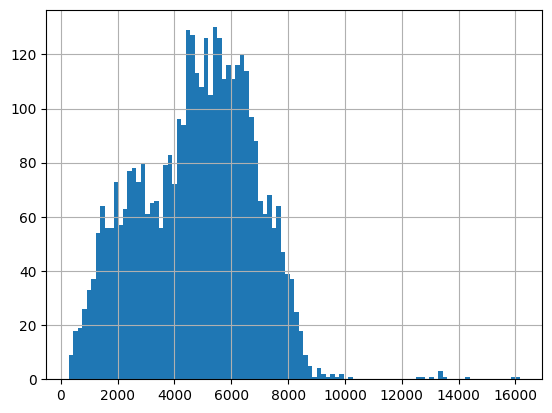

In [11]:
df_train.bike_count.hist(bins=100, label='obs')


Another useful plotting tool is Seaborn.

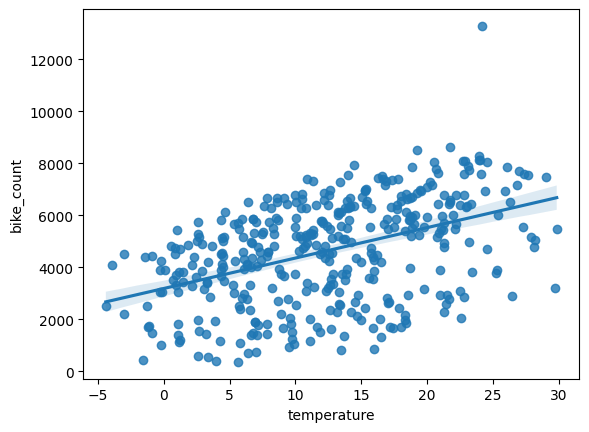

In [12]:
# Only take every 10th value
sns.regplot(data=df_train.iloc[::10], x='temperature', y='bike_count');

Check for NAs

In [13]:
df_train.isna().sum()

date                        0
bike_count                  0
temperature                 0
humidity                    0
windspeed                   0
wind_direction              0
visibility                  0
precipitation               0
sun                         0
windspeed_max               0
precip_indic                0
precip_type                 0
school_holiday_indicator    0
public_holiday_indicator    0
is_workday                  0
dtype: int64

**Our first Kaggle submission**

First, we read the test data.

In [14]:
df_test = pd.read_csv("/kaggle/input/umr-ml-2025-hackathon-1/data_test.csv")
df_test['date'] = pd.to_datetime(df_test['date'])

In [15]:
df_test.head()

,date,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday_indicator,public_holiday_indicator,is_workday
0,2023-01-01,13.527778,66.555556,3.161111,207.777778,57907.777778,0.0,196,10.0,0.0,0,1,1,0
1,2023-01-02,10.316667,79.722222,3.072222,204.444444,50496.666667,1.6,99,12.6,0.0,0,1,0,1
2,2023-01-03,6.027778,88.222222,1.622222,199.444444,45582.777778,0.0,347,5.5,0.0,0,1,0,1
3,2023-01-04,8.911111,77.166667,8.944444,227.777778,46587.777778,0.3,0,17.2,0.0,0,1,0,1
4,2023-01-05,10.977778,81.944444,6.066667,233.333333,40345.555556,0.3,22,14.3,0.0,0,1,0,1


In [16]:
df_test.columns

Index(['date', 'temperature', 'humidity', 'windspeed', 'wind_direction',
       'visibility', 'precipitation', 'sun', 'windspeed_max', 'precip_indic',
       'precip_type', 'school_holiday_indicator', 'public_holiday_indicator',
       'is_workday'],
      dtype='object')

These are the same columns as in the training data, but of course without the target variable.

As a first simple model, let's always **predict the mean from the training dataset**. The following function allows to create a submission in the correct format from a vector of predictions `preds`.

In [17]:
def create_sub(preds, fn=None):
    df =  pd.DataFrame({'id': range(len(preds)), 'Prediction': preds})
    return df

Here, we just compute the mean from the training data and repeat it for every test case.

In [18]:
df_sub = create_sub([df_train.bike_count.mean()]*len(df_test))

In [19]:
df_sub

,id,Prediction
0,0,4767.051507
1,1,4767.051507
2,2,4767.051507
3,3,4767.051507
4,4,4767.051507
...,...,...
385,385,4767.051507
386,386,4767.051507
387,387,4767.051507
388,388,4767.051507


In [20]:
def add_date_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
    return df

In [21]:
train = add_date_features(df_train)
test = add_date_features(df_test)

In [22]:
train.ffill(inplace=True)
test.ffill(inplace=True)

In [23]:
# ---------- 이상치 제거 ----------
train = train[train['bike_count'] < 30000]

In [24]:
features = [
    'temperature', 'humidity', 'windspeed', 'wind_direction',
    'visibility', 'precipitation', 'sun', 'windspeed_max',
    'precip_indic', 'precip_type',
    'school_holiday_indicator', 'public_holiday_indicator', 'is_workday',
    'year', 'month', 'weekday', 'is_weekend'
]

In [25]:
X = train[features]
y = train['bike_count']
X_test = test[features]

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    verbose=100
)

model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)
y_pred = model.predict(X_val)

0:	learn: 1923.0299975	test: 2014.1640376	best: 2014.1640376 (0)	total: 57ms	remaining: 57s
100:	learn: 686.8350432	test: 836.8567429	best: 836.8567429 (100)	total: 237ms	remaining: 2.11s
200:	learn: 574.0500517	test: 771.0482084	best: 771.0482084 (200)	total: 403ms	remaining: 1.6s
300:	learn: 499.7567524	test: 746.9863129	best: 746.9863129 (300)	total: 574ms	remaining: 1.33s
400:	learn: 450.6573038	test: 736.3966684	best: 736.3096187 (395)	total: 753ms	remaining: 1.13s
500:	learn: 413.3187027	test: 731.7231166	best: 731.3733096 (493)	total: 921ms	remaining: 917ms
600:	learn: 381.3599830	test: 726.3547665	best: 726.3547665 (600)	total: 1.1s	remaining: 728ms
700:	learn: 357.9335504	test: 722.8398129	best: 722.8398129 (700)	total: 1.27s	remaining: 542ms
800:	learn: 336.2252229	test: 722.1318448	best: 721.9245222 (797)	total: 1.44s	remaining: 358ms
900:	learn: 314.9214550	test: 721.2716504	best: 720.7587863 (867)	total: 1.61s	remaining: 178ms
999:	learn: 296.9645955	test: 720.3003141	best

In [27]:
val_preds = model.predict(X_val)
mae = mean_absolute_error(y_val, val_preds)
print(f"Validation MAE: {mae:.2f}")

Validation MAE: 381.84


In [28]:
sample_submission = pd.read_csv('/kaggle/input/umr-ml-2025-hackathon-1/test_submission.csv')

# prediction
test_preds = model.predict(X_test)

# save
submission = pd.DataFrame({
    'id': sample_submission['id'],
    'Prediction': np.round(test_preds).astype(int)
})

# CSV save
submission.to_csv('submission.csv', index=False)
print("✅ submission.csv 저장 완료")

✅ submission.csv 저장 완료


This data frame can be converted to a csv file. 

**Linear regression model**

As a slightly more complex alternative, let's also consider a linear regression model.

We first drop the date information.

To build a LR model, we use functionalities from the scikitlearn package.

We can now take a look at the estimated parameters.

Note the inherent interpretability of the model coefficients (larger absolute values correspond to "more important" influence of the corresponding predictors). Further, for example for 'is_workday' the coefficient can be interpreted as follows: When increasing the feature by 1 (i.e., going from 0 to 1), and leaving everything else constant, we can expect an increase in the target variable by around 2637. If 'temperature', increases by 1 degree Celsius, we can expect on average 121 bikes more (leaving everythign else constant) according to the model.

**Considerations for models**

- How to treat outliers? What is an outlier?
- How to best utilize information in the input features?
- How informative are certain features, e.g., precipitation type and indicator?
- What other, potentially useful, information can be extracted?
- We might want to split the training data into training and validation data to choose hyperparameters.


Some starting points:

**Weekday information**

<Axes: xlabel='date', ylabel='bike_count'>

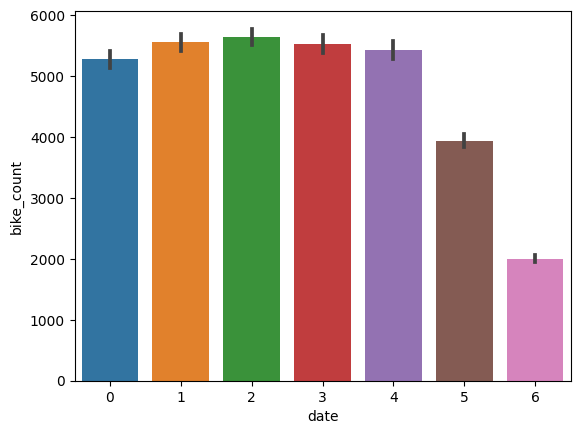

In [29]:
sns.barplot(data=df_train, x= df_train['date'].dt.weekday , y = 'bike_count')
# Monday = 0

**Correlation Matrix**

In [30]:
correlation_matrix = df_train.corr(numeric_only=True)  
correlation_matrix

,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,precip_type,school_holiday_indicator,public_holiday_indicator,is_workday,year,month,day,weekday,is_weekend
bike_count,1.000000,0.482530,-0.366172,-0.211868,-0.027278,0.209376,-0.218455,0.406989,-0.142020,-0.295623,-0.292796,-0.025964,-0.283459,0.640148,0.014806,0.093921,0.004874,-0.470640,-0.564091
temperature,0.482530,1.000000,-0.603229,-0.131444,0.118907,0.490243,-0.020292,0.586324,0.028486,-0.203915,-0.209622,0.233536,-0.043018,0.010816,-0.000889,0.150182,0.013424,0.006397,0.000142
humidity,-0.366172,-0.603229,1.000000,-0.041803,0.183248,-0.601747,0.298716,-0.792583,-0.122864,0.422234,0.419270,-0.150886,0.044913,-0.019796,-0.139145,0.201197,-0.030313,0.007359,0.013604
windspeed,-0.211868,-0.131444,-0.041803,1.000000,0.104963,0.184163,0.186417,-0.233792,0.839175,0.325412,0.305584,-0.036417,-0.014332,-0.014800,0.013183,-0.148962,0.014400,0.006337,0.018777
wind_direction,-0.027278,0.118907,0.183248,0.104963,1.000000,0.151833,0.168407,-0.230804,0.172586,0.211034,0.198664,0.067383,0.008915,0.012733,-0.037043,0.039292,-0.008178,-0.012587,-0.015293
visibility,0.209376,0.490243,-0.601747,0.184163,0.151833,1.000000,-0.095952,0.402015,0.301689,-0.149796,-0.163314,0.132694,-0.003699,0.008679,0.337759,-0.022312,-0.001807,-0.021975,-0.014699
precipitation,-0.218455,-0.020292,0.298716,0.186417,0.168407,-0.095952,1.000000,-0.287452,0.278492,0.497588,0.469996,-0.014344,0.008619,-0.028631,-0.012596,0.019580,-0.028204,0.031889,0.025413
sun,0.406989,0.586324,-0.792583,-0.233792,-0.230804,0.402015,-0.287452,1.000000,-0.130442,-0.463618,-0.461409,0.115432,-0.022395,0.005275,0.050080,-0.079020,0.033633,0.002418,-0.004247
windspeed_max,-0.142020,0.028486,-0.122864,0.839175,0.172586,0.301689,0.278492,-0.130442,1.000000,0.288072,0.272293,0.000521,-0.013059,-0.005384,0.019008,-0.142998,-0.006939,0.004578,0.006043
precip_indic,-0.295623,-0.203915,0.422234,0.325412,0.211034,-0.149796,0.497588,-0.463618,0.288072,1.000000,0.899434,-0.055335,0.025297,-0.007670,-0.015445,-0.005677,-0.035657,-0.008896,0.001226


<Axes: >

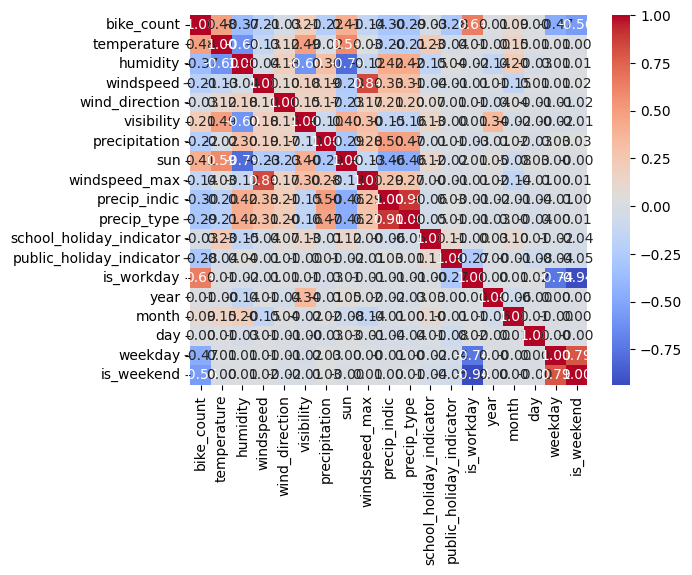

In [31]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")